In [1]:
suppressPackageStartupMessages(library(dplyr))
library(ggplot2)
suppressPackageStartupMessages(library(Seurat))
library(pheatmap)
library(RColorBrewer)
library(harmony)
source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT/BICAN_help.R")

### this is just to resize jupyter notebook plot size
library(repr)

Warning message:
“package ‘ggplot2’ was built under R version 4.4.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”
Warning message:
“package ‘sp’ was built under R version 4.4.2”
Loading required package: Rcpp

Warning message:
“package ‘scales’ was built under R version 4.4.3”
Warning message:
“package ‘Matrix’ was built under R version 4.4.3”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [3]:
cols <- read.csv("./ref/yel_Science2023_supp/subclass_celltype_match.csv")
tmp <- distinct(cols[,c("Cell.class", "Cell.class.color")])
ccol1 <- tmp$Cell.class.color
names(ccol1) <- gsub("GLUT", "Glut", tmp$Cell.class)

atac2r <- read.table("../06.integration/snATAC_DPT_RNA_250601.pred_subclass_match.txt", header = T)
ccol2 <- c("#e045c3", '#773299', '#9b556c', '#7d5d8b', '#968aff', '#2171cb', '#9b556c', '#ff77b7','#00609b','#019c99', 
           '#03afcf','#00ce80', '#70a47c', '#099dff', '#00bcfa', '#00d1f9', '#7fbb7a', '#01a4f1', '#674f10', '#f4bc71', '#ed5764',
           '#ff7985', '#b65f00', '#e83038', '#bd5378', '#ae001d', '#ec2e82', '#ffa179', '#bd7580', '#959700', '#23832c', '#ff7560', 
           '#64d8cd', '#88475c')
names(ccol2) <- unique(atac2r$MiniAtlas)

In [4]:
lmeta <- read.csv("./analysis/04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250722_metadata.txt", 
                  sep = "\t", row.names = 1)
dim(lmeta)

[1] 751077     39

## Subset for CCA integration

In [2]:
## Subset 1k per subclass
mmg <- qs::qread("../04.clustering/02.RNA/03.l3_clustering/MiniAtlas_RNA_merged_dual_filt_clean_corrected_250529.qs")
tmp <- subset(mmg, subset = keep == 1)

In [3]:
cts <- list()
i = 1
for (cls in unique(tmp$cluster_manual_name)){
    if (nrow(tmp@meta.data[tmp$cluster_manual_name == cls,]) >= 250){
        cts[[i]] <- sample(rownames(tmp@meta.data[tmp$cluster_manual_name == cls,]), size = 250, replace = F)
    }else{
        cts[[i]] <- rownames(tmp@meta.data[tmp$cluster_manual_name == cls,])
    }
    i = i + 1
}
mmg <- subset(mmg, cells = unlist(cts))
mmg

qs::qsave(mmg, "./analysis/06.integration/MiniAtlas_RNA_merged_dual_filt_clean_250520_subset_cluster_for_int.qs")

An object of class Seurat 
38369 features across 36744 samples within 1 assay 
Active assay: RNA (38369 features, 3000 variable features)
 3 layers present: data, counts, scale.data
 5 dimensional reductions calculated: pca, harmony, umap, k27ac_umap, k27me3_umap

In [5]:
### Read Siletti 2023
ref1 <- readRDS("./ref/hba_10XRNA/stenRNA.annotation.selt.regionMatch_cluster.genename.rds")

### Read SMART-seq
ref2 <- qs::qread("./ref/human_cortex_smartseq/data/rna_subset_for_int.qs")
obj_list <- list(ref1, ref2, mmg)
for (i in 1:length(obj_list)) {
    obj_list[[i]] <- NormalizeData(obj_list[[i]], verbose = FALSE)
    obj_list[[i]] <- FindVariableFeatures(obj_list[[i]], selection.method = "vst", 
                                          nfeatures = 3000, verbose = FALSE)
}

In [13]:
### Run Integration: Seurat v5
obj <- merge(mmg, c(ref1, ref2))
obj <- NormalizeData(obj)
obj <- FindVariableFeatures(obj)
obj <- ScaleData(obj, verbose = FALSE)
obj <- RunPCA(obj, npcs = 50, verbose = FALSE)
intobj <- IntegrateLayers(object = obj, method = CCAIntegration, assay = "RNA", 
                          new.reduction = "integrated.cca")

Normalizing layer: counts.1

Normalizing layer: counts.2

Normalizing layer: counts.3

Finding variable features for layer counts.1

Finding variable features for layer counts.2

Finding variable features for layer counts.3

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 42624 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 33001 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 26971 anchors

Merging dataset 1 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 3 into 2 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data



In [17]:
significant_pc_test(intobj@reductions$integrated.cca@cell.embeddings, min_pc = 15)

[1] "Downsample PC matrix to 25000 cells to calculate significant PC components"


[1] 50

In [18]:
intobj <- FindNeighbors(intobj, reduction = "integrated.cca", dims = 1:50)
intobj <- FindClusters(intobj, resolution = 1)
intobj <- RunUMAP(intobj, dims = 1:50, reduction = "integrated.cca")

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 111363
Number of edges: 5926376

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9575
Number of communities: 58
Elapsed time: 36 seconds


20:24:50 UMAP embedding parameters a = 0.9922 b = 1.112

20:24:50 Read 111363 rows and found 50 numeric columns

20:24:50 Using Annoy for neighbor search, n_neighbors = 30

20:24:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:25:03 Writing NN index file to temp file /tmp/RtmpYLb9kw/file36941cc4b154

20:25:04 Searching Annoy index using 1 thread, search_k = 3000

20:25:43 Annoy recall = 100%

20:25:43 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

20:25:47 Initializing from normalized Laplacian + noise (using RSpectra)

20:26:45 Commencing optimization for 200 epochs, with 5279324 positive edges

20:26:45 Using rng type: pcg

20:27:37 Optimization finished



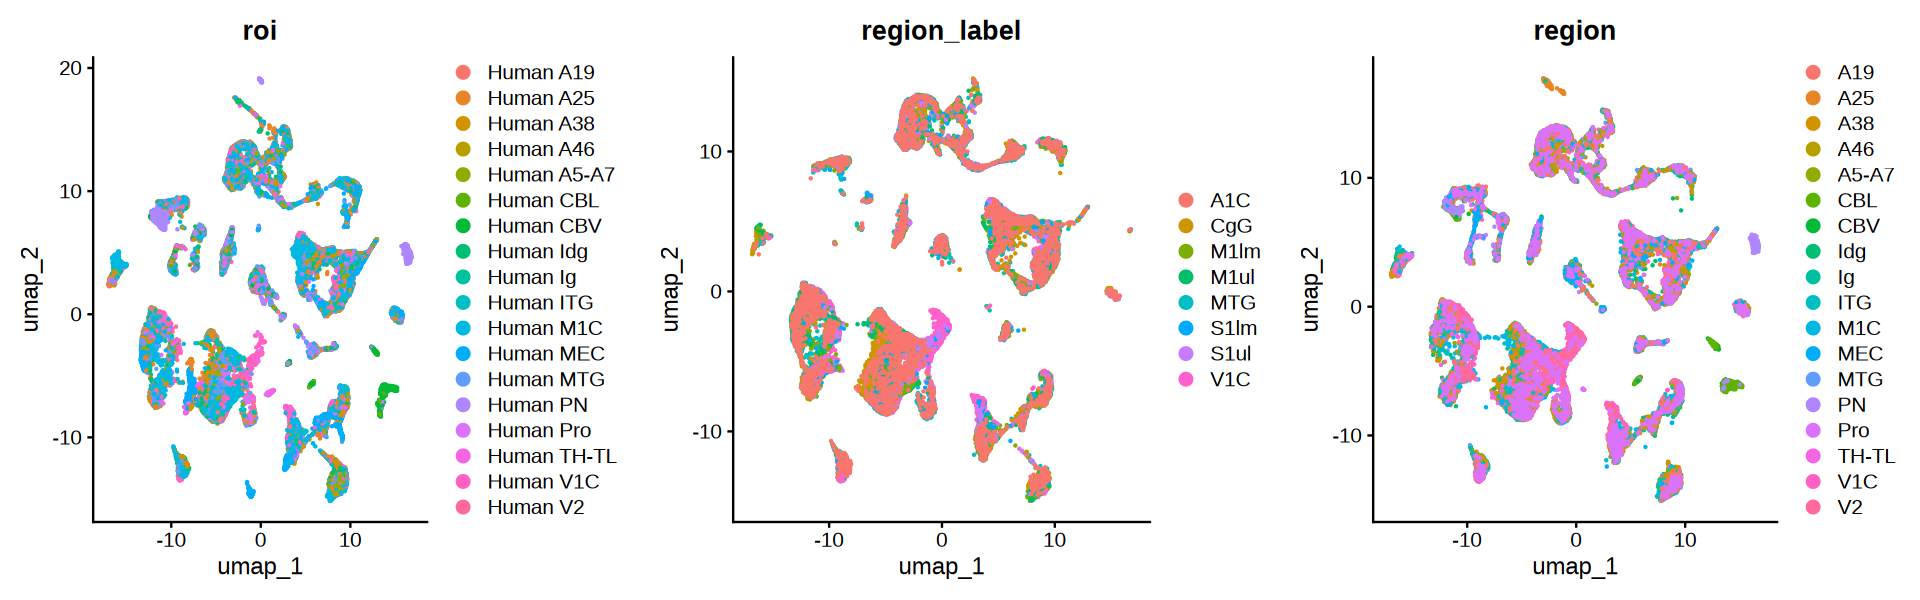

In [19]:
intobj@meta.data[!is.na(obj$roi), ]$orig.ident <- "Siletti"
intobj@meta.data[!is.na(obj$outlier_type), ]$orig.ident <- "SMARTseq"
intobj@meta.data[!is.na(obj$subclass_corrected), ]$orig.ident <- "MiniAtlas"


t1 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "Siletti",]), 
              group.by = "roi", label = F, repel = T) #+ NoLegend()
t2 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "SMARTseq",]), 
              group.by = "region_label", label = F, repel = T) #+ NoLegend()
t3 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "MiniAtlas",]), 
              group.by = "region", label = F, repel = T) #+ NoLegend()

options(repr.plot.width = 16, repr.plot.height = 5)
cowplot::plot_grid(t1, t2, t3, ncol = 3)

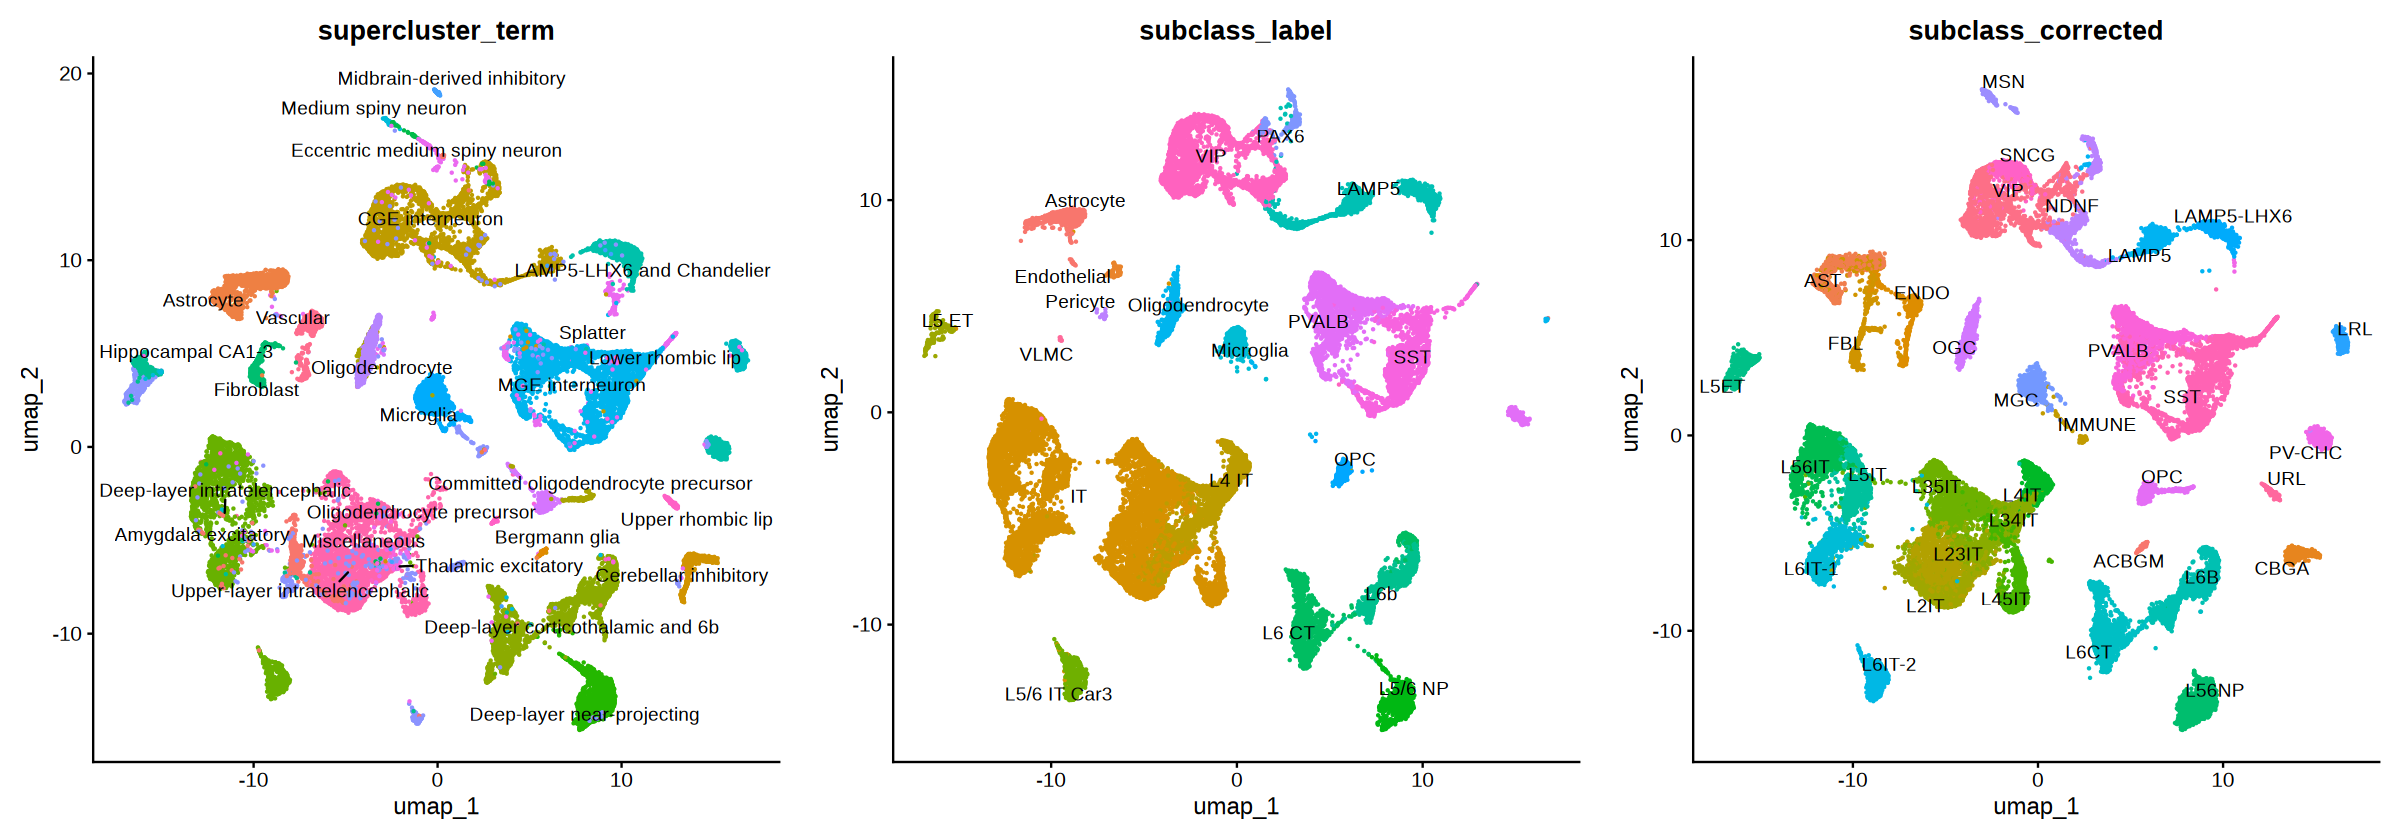

In [20]:
options(repr.plot.width = 20, repr.plot.height = 7)

t1 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "Siletti",]), 
              group.by = 'supercluster_term', label = T, repel = T) + NoLegend()
t2 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "SMARTseq",]), 
              group.by = "subclass_label", label = T, repel = T) + NoLegend()
t3 <- DimPlot(intobj, cells = rownames(intobj@meta.data[intobj$orig.ident == "MiniAtlas",]), 
              group.by = 'subclass_corrected', label = T, repel = T) + NoLegend()
cowplot::plot_grid(t1, t2, t3, ncol = 3)

In [27]:
qs::qsave(intobj, "../06.integration/stenRNA_miniatlas_smartseq_cluster_manual_250722.int.qs")

### Calculate overlap score

Using ovlpScore as value column: use value.var to override.



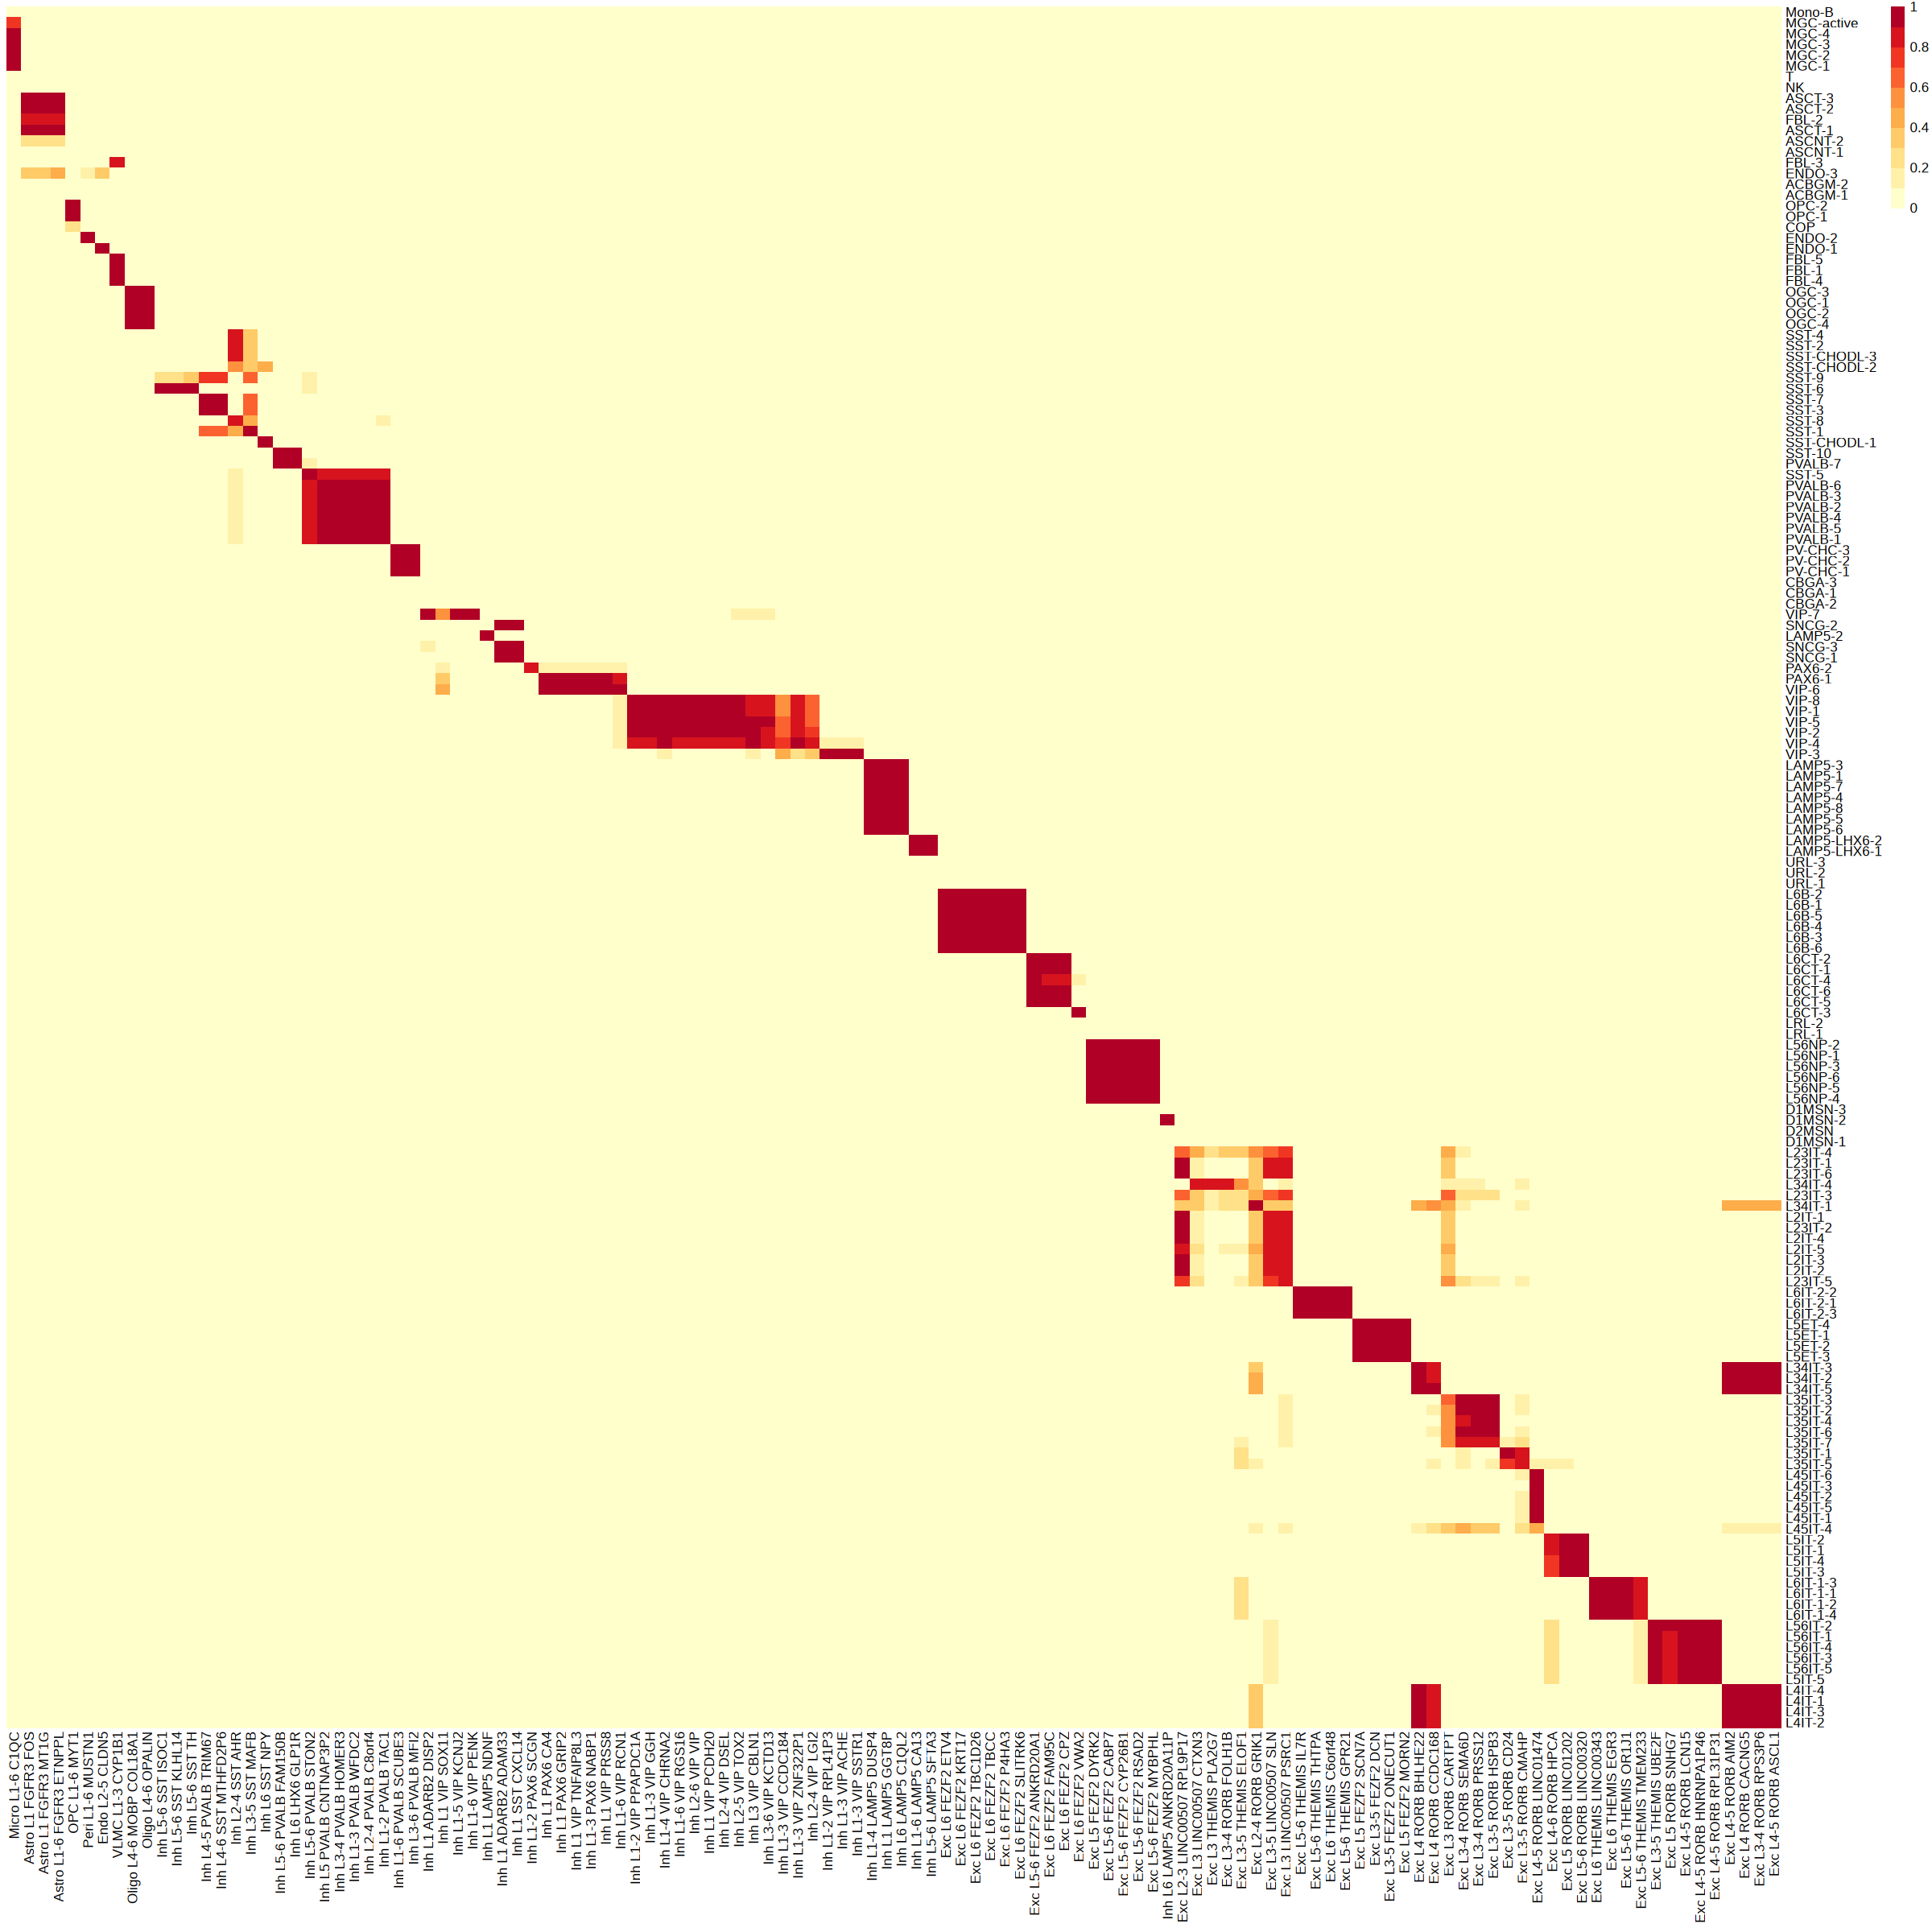

In [29]:
### vs SMART-seq
corder2 <- read.table("../04.clustering/order.cluster.250601", sep = "\t") %>% select(V1) %>% unlist %>% as.character

t1 <- intobj@meta.data[intobj$orig.ident == "MiniAtlas", c("seurat_clusters", "cluster_manual_name")]
t2 <- intobj@meta.data[intobj$orig.ident == "SMARTseq", c("seurat_clusters", "cluster_label")]
qtk1 <- names(which(table(t1$cluster_manual_name) >= 5))
ovlp_score <- cal_ovlpScore(t1[t1$cluster_manual_name %in% qtk1,], t2)

rmat <- ovlp_score %>%
reshape2::dcast(anno1 ~ anno2) %>%
tibble::column_to_rownames("anno1") %>% t

ctk <- which(apply(rmat, 1, max) > 0.05)
rmat <- rmat[ctk, corder2]

max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ] %>% t

options(repr.plot.width = 20, repr.plot.height = 20)
p1 <- smat %>% 
pheatmap(cluster_rows = F, cluster_cols = F, border_color = "white", angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))

Using ovlpScore as value column: use value.var to override.



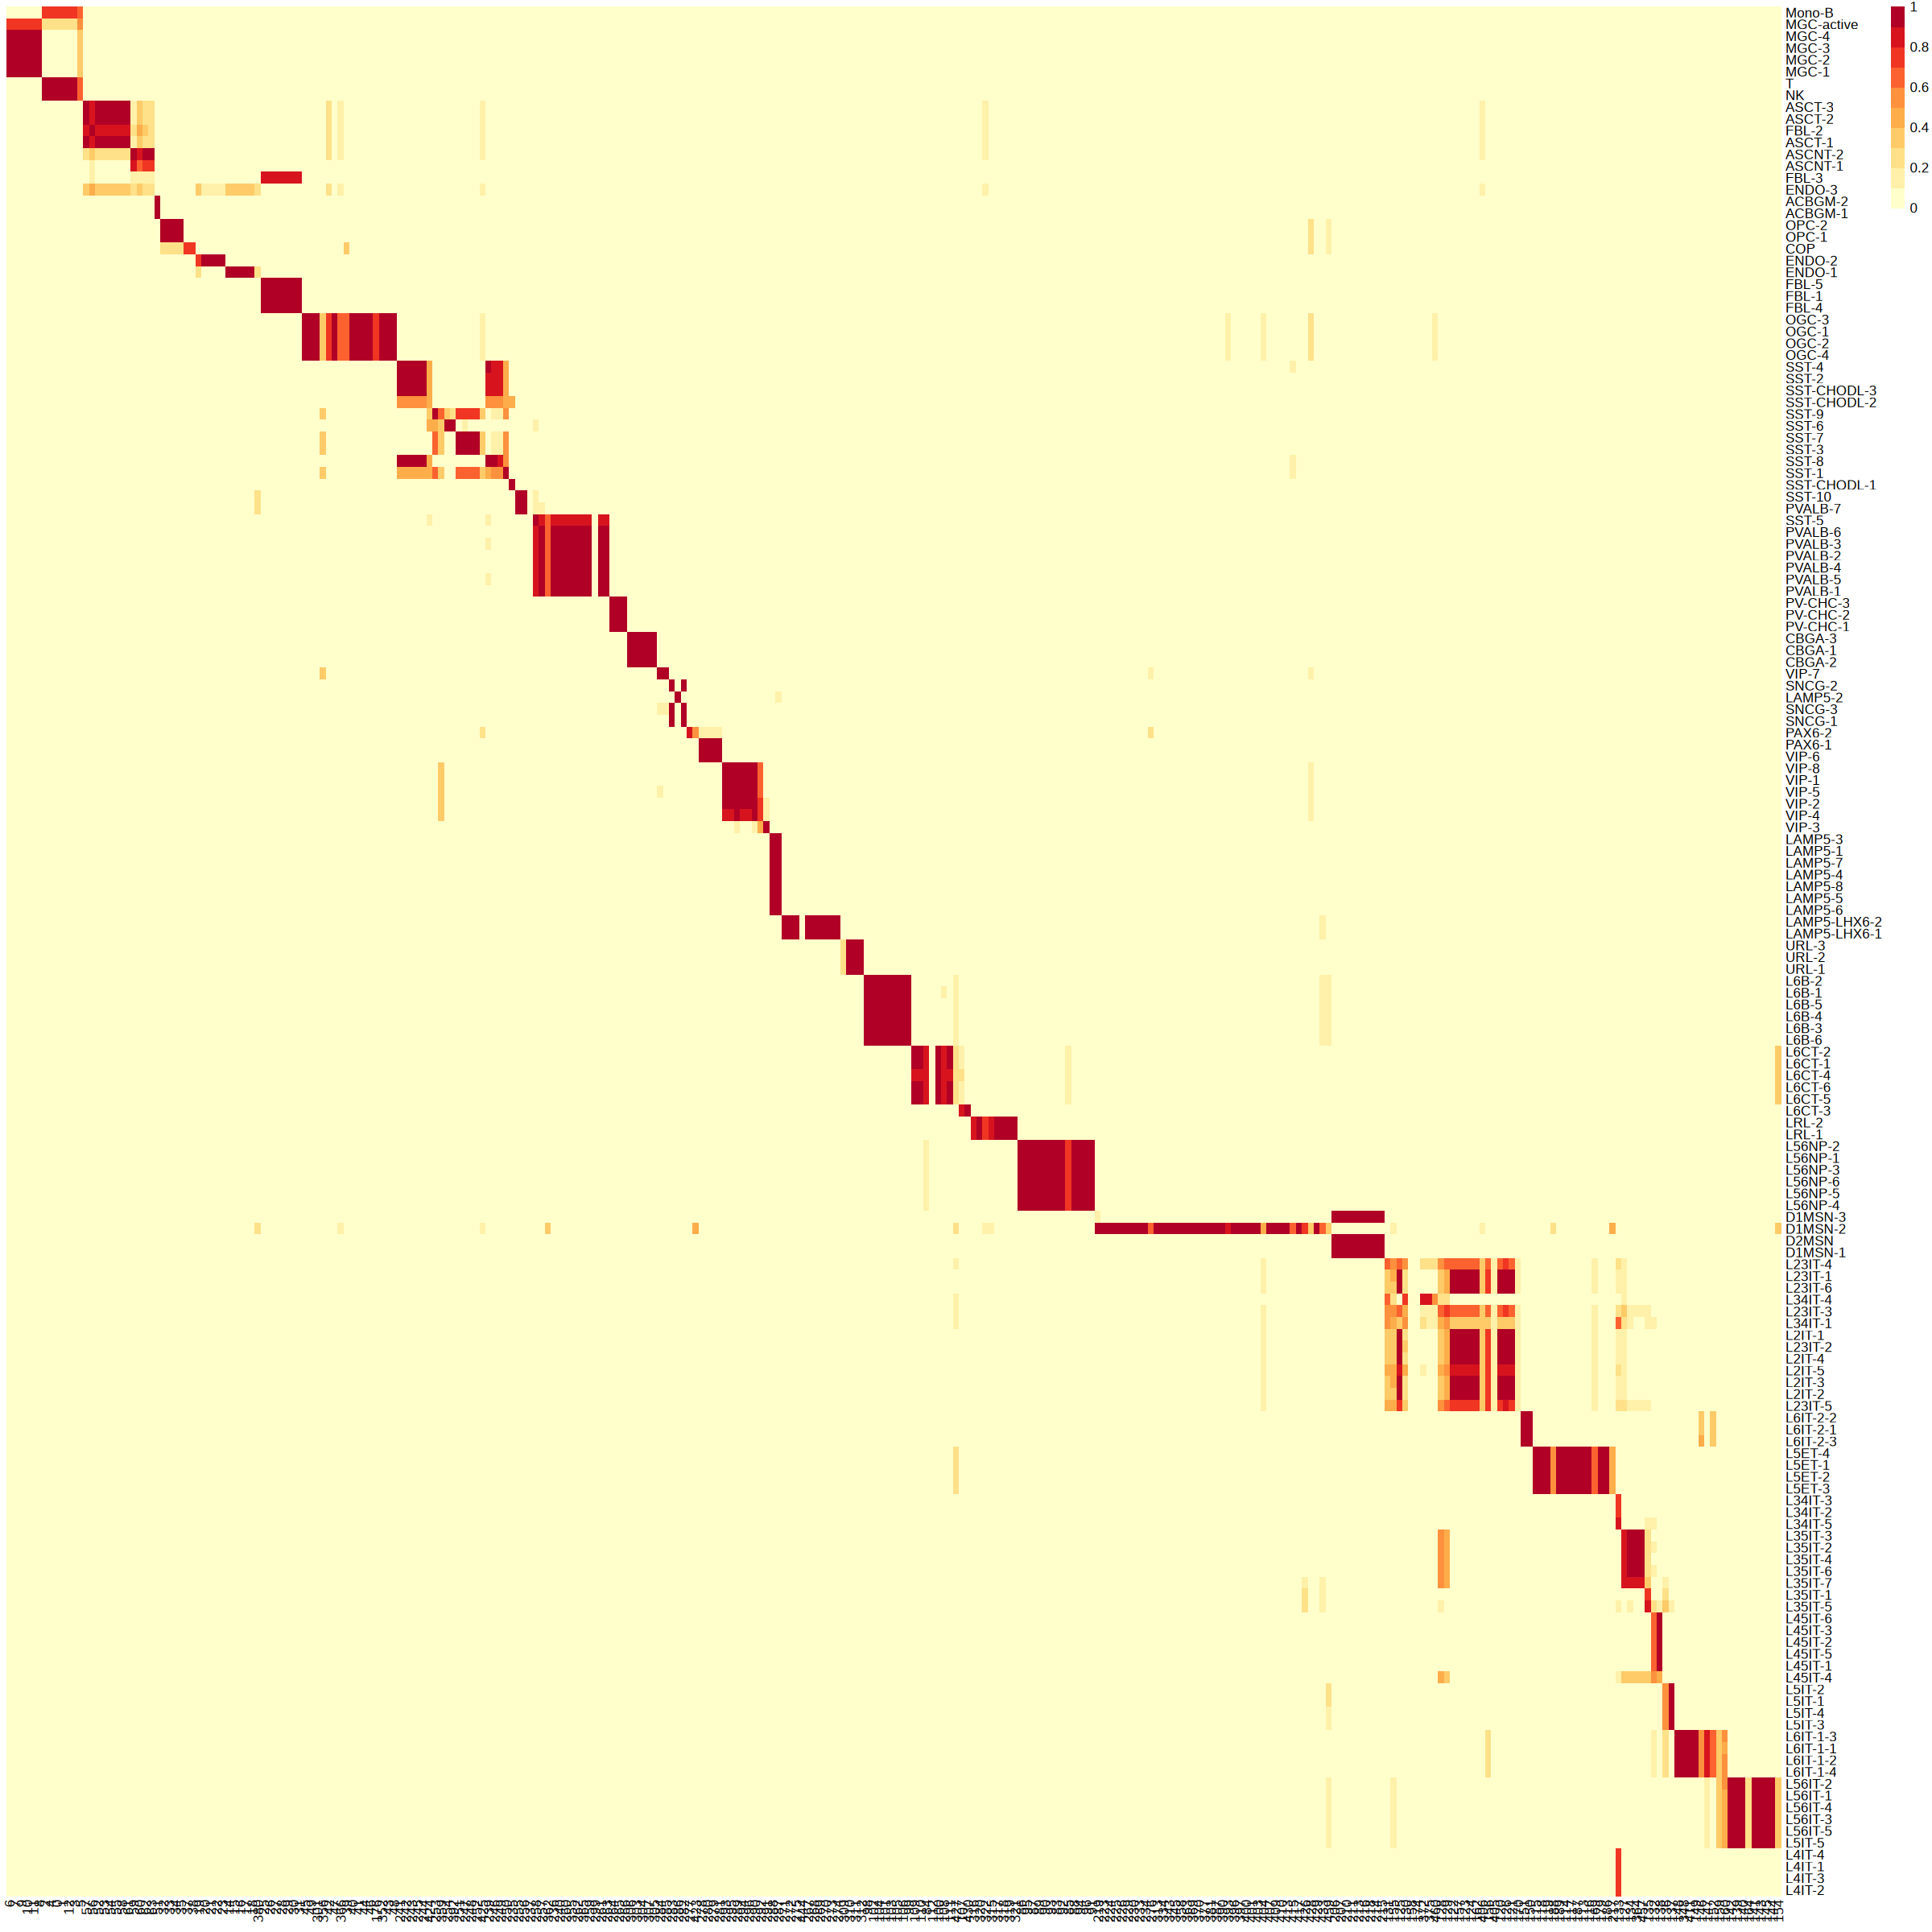

In [42]:
### vs siletti
t1 <- intobj@meta.data[intobj$orig.ident == "MiniAtlas", c("seurat_clusters", "cluster_manual_name")]
t2 <- intobj@meta.data[intobj$orig.ident == "Siletti", c("seurat_clusters", "cluster_id")]
qtk1 <- names(which(table(t1$cluster_manual_name) >= 5))
ovlp_score <- cal_ovlpScore(t1[t1$cluster_manual_name %in% qtk1,], t2)

rmat <- ovlp_score %>%
reshape2::dcast(anno1 ~ anno2) %>%
tibble::column_to_rownames("anno1") %>% t

ctk <- which(apply(rmat, 1, max) > 0.05)
rmat <- rmat[ctk, corder2]

max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat2 <- rmat[permutation_vector, ] %>% t

options(repr.plot.width = 20, repr.plot.height = 20)
p2 <- smat2 %>% 
pheatmap(cluster_rows = F, cluster_cols = F, border_color = "white", angle_col = 90, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlOrRd"))(10))